# 20220120 Initial Analysis

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import numpy as np
from importlib import reload
from imaka.analysis import plot_stats
from imaka.analysis import plot_redu
from imaka.reduce import util
from astropy.stats import sigma_clipped_stats

## Edit Me
from imaka.reduce.nights import reduce_2022_01_20 as redu
night = '20220120'
fld = 'Beehive-W'

root_dir = redu.root_dir
stats_dir = root_dir + "reduce/stats/"
plots_dir = root_dir + "reduce/plots/"
stack_dir = root_dir + "reduce/stacks/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
## Had an issue with stacking, the gfol
for key in ['LS_3wfs_r2', 'LS_5wfs_r2', 'open_r2']:
    for i in range(len(redu.dict_images[key])):
        img_num = redu.dict_images[key]
        suf = redu.dict_suffix[key]
        test_img_base = 'sta{img:03d}{suf:s}_scan'.format(img=img_num[i], suf=suf)
        
        stars = Table.read(root_dir + f'reduce/{fld}/' + test_img_base + '_clean_stars_stats_mdp.fits')
        print(f"key: {key} image {img_num[i]} stars: {len(stars)}")  

key: LS_3wfs_r2 image 88 stars: 52
key: LS_3wfs_r2 image 91 stars: 61
key: LS_3wfs_r2 image 94 stars: 56
key: LS_3wfs_r2 image 105 stars: 49
key: LS_3wfs_r2 image 108 stars: 62
key: LS_3wfs_r2 image 111 stars: 52
key: LS_3wfs_r2 image 114 stars: 54
key: LS_3wfs_r2 image 117 stars: 65
key: LS_3wfs_r2 image 120 stars: 51
key: LS_3wfs_r2 image 123 stars: 57
key: LS_3wfs_r2 image 126 stars: 61
key: LS_3wfs_r2 image 129 stars: 58
key: LS_5wfs_r2 image 87 stars: 62
key: LS_5wfs_r2 image 90 stars: 59
key: LS_5wfs_r2 image 93 stars: 55
key: LS_5wfs_r2 image 96 stars: 56
key: LS_5wfs_r2 image 104 stars: 60
key: LS_5wfs_r2 image 107 stars: 76
key: LS_5wfs_r2 image 110 stars: 60
key: LS_5wfs_r2 image 113 stars: 65
key: LS_5wfs_r2 image 116 stars: 64
key: LS_5wfs_r2 image 119 stars: 60
key: LS_5wfs_r2 image 122 stars: 59
key: LS_5wfs_r2 image 125 stars: 72
key: LS_5wfs_r2 image 128 stars: 67
key: open_r2 image 89 stars: 35
key: open_r2 image 92 stars: 36
key: open_r2 image 95 stars: 38
key: open_r

## Reduction inputs

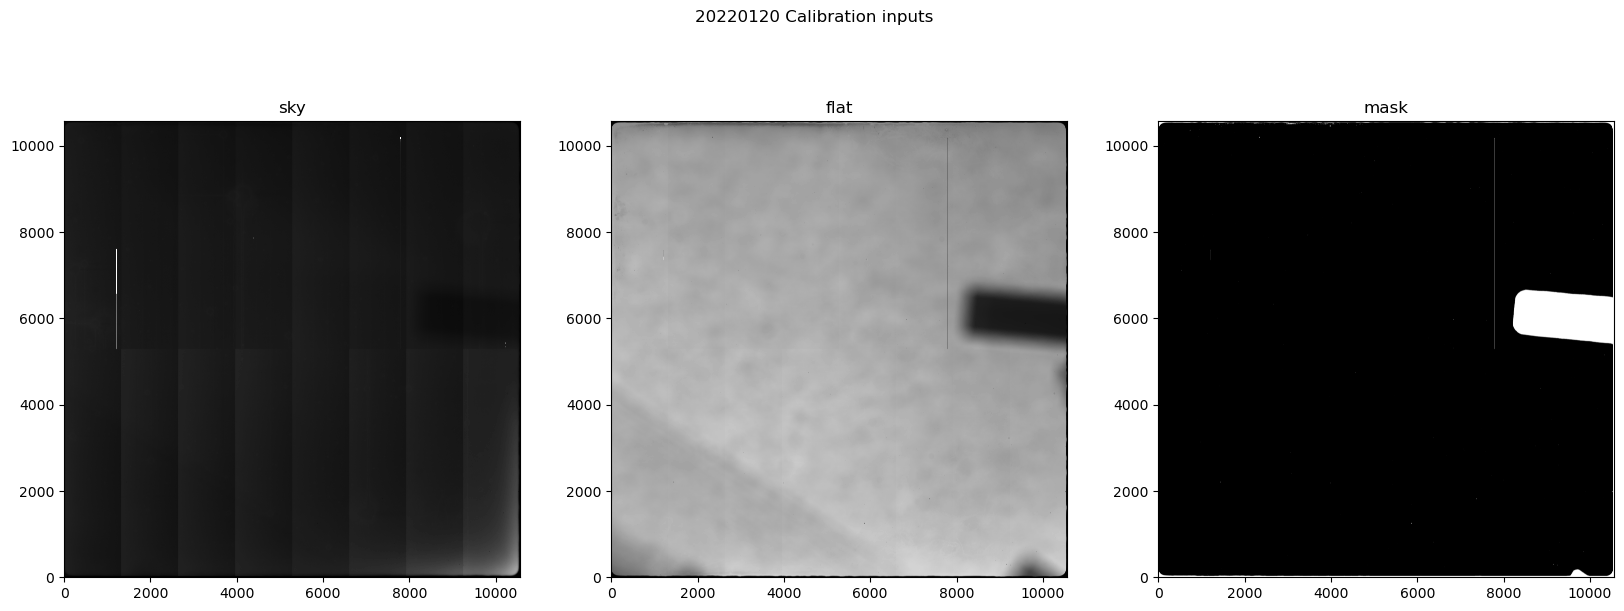

In [4]:
## sky, flats, and mask

sky_f = redu.sky_dir + "beehive_sky.fits"
flat_f = redu.calib_dir + "flat.fits"
mask_f = redu.calib_dir + "mask.fits"

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,7))
fig.suptitle(night + ' Calibration inputs')

ax0.set_title('sky')
image_data = fits.getdata(sky_f)
ax0.imshow(image_data, cmap='gray', vmin=0, vmax=1000, origin='lower')

ax1.set_title('flat')
image_data = fits.getdata(flat_f)
ax1.imshow(image_data, cmap='gray', vmin=0, vmax=1.5, origin='lower')

ax2.set_title('mask')
image_data = fits.getdata(mask_f)
ax2.imshow(image_data, cmap='gray', vmin=0, vmax=1, origin='lower')

plt.show()

## Real time plots

Play with a star list and look at trends in FWHM, etc. 

In [5]:
# Enter chosen file
test_img_base = 'sta088n3wfs_c_scan' # this is the test single code

In [52]:
# pick a file based on key
key = 'open_r2'
i=1

img_num = redu.dict_images[key]
suf = redu.dict_suffix[key]
test_img_base = 'sta{img:03d}{suf:s}_scan'.format(img=img_num[i], suf=suf)

In [53]:
reload(plot_redu)

<module 'imaka.analysis.plot_redu' from '/u/eden/code/imaka/imaka/analysis/plot_redu.py'>

50% EE radius = 0.850"


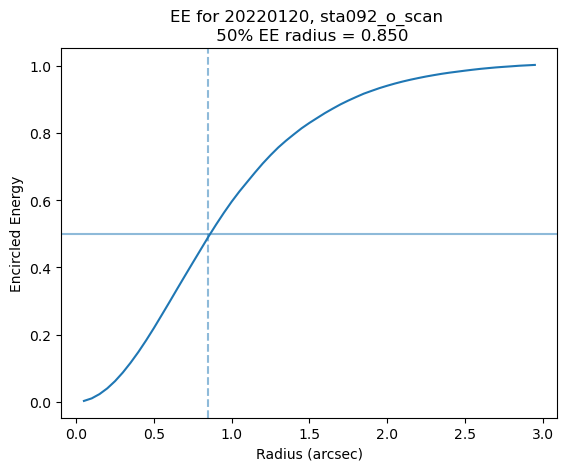

In [54]:
plot_redu.plot_ee_50(test_img_base, root_dir, fld, night)

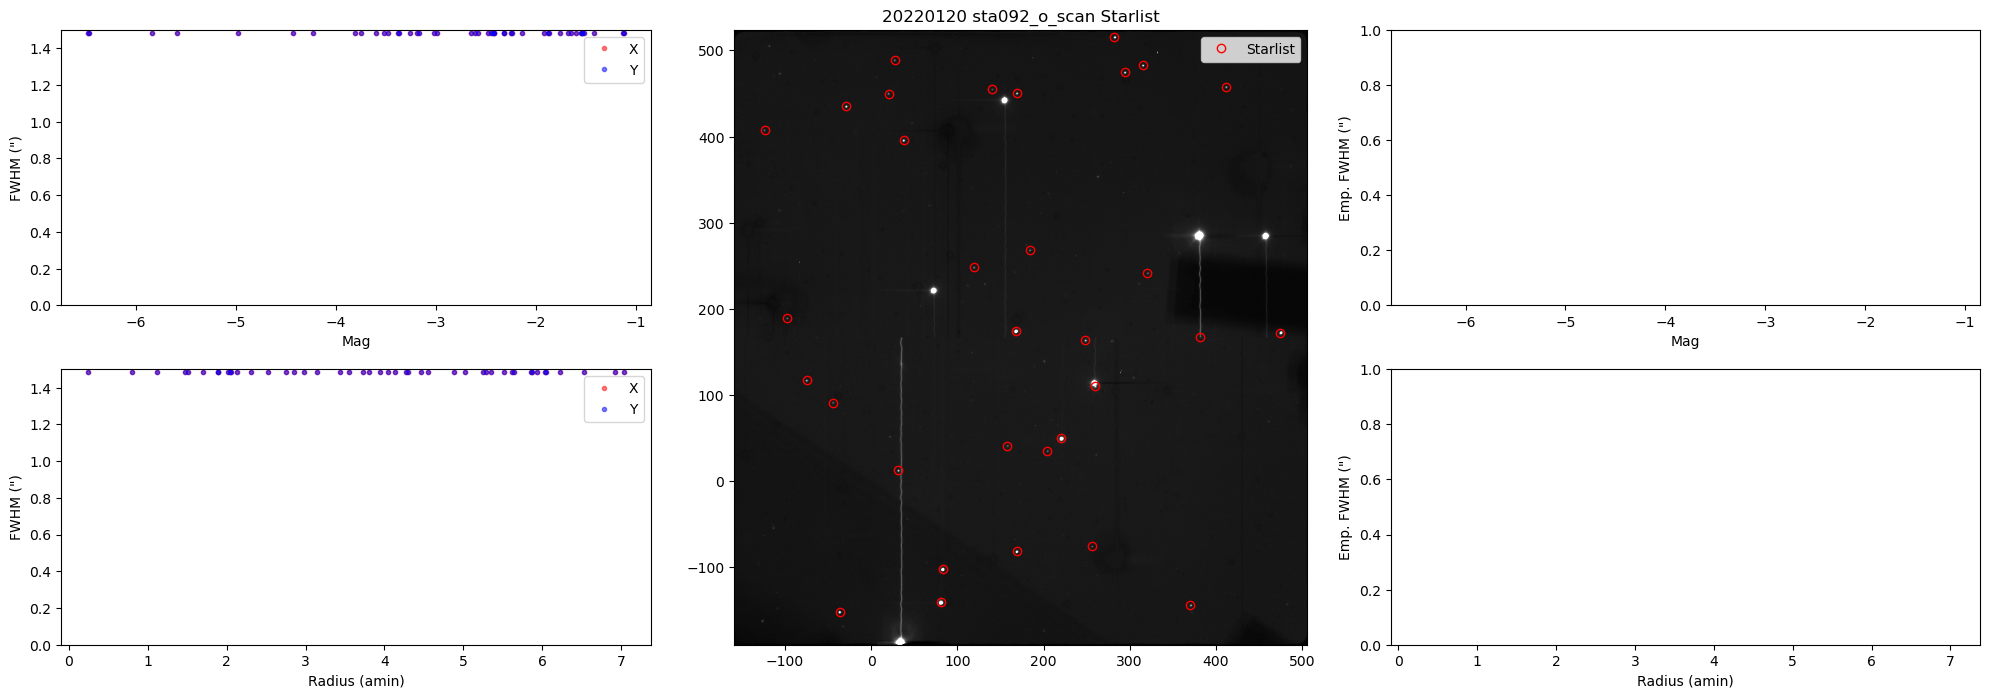

x: fwhm_x_avg = 1.48" fwhm_x_med = 1.48" fwhm_x_std = 0.00"
x: fwhm_x_avg = 1.48" fwhm_x_med = 1.48" fwhm_x_std = 0.00"


In [55]:
plot_redu.plot_starlist_stats(test_img_base, root_dir, fld, night)

In [78]:
img, hdr = fits.getdata(root_dir + f'{fld}/' + test_img_base + '.fits', header=True)
scale = util.get_plate_scale(img, hdr)
del img
del hdr


In [79]:
0.15/scale

2.380952380952381

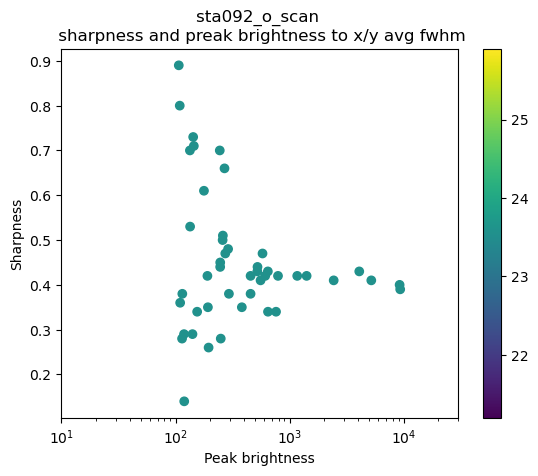

In [56]:
# num pix vs fwhm
stars = Table.read(root_dir + f'reduce/{fld}/' + test_img_base + '_clean_stars.txt', format='ascii')

plt.scatter(stars['peak'], stars['sharpness'], c=np.average([stars['x_fwhm'], stars['y_fwhm']], axis=0))
plt.xlim(10, 30000)
plt.xscale('log')
plt.xlabel("Peak brightness")
plt.ylabel("Sharpness")
plt.title(test_img_base+ " \n sharpness and preak brightness to x/y avg fwhm")
plt.colorbar()

In [40]:
0.15/scale

2.380952380952381

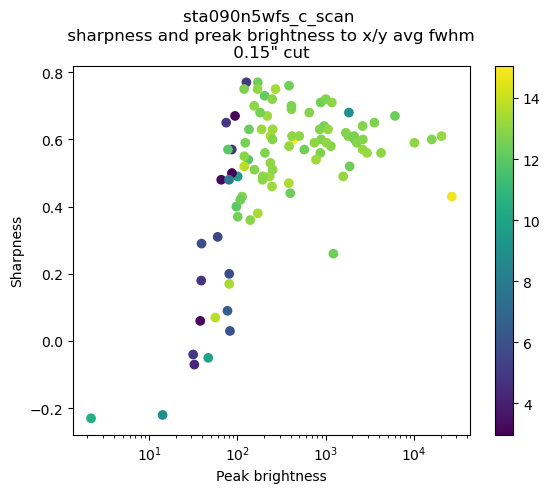

In [39]:
scale=0.063
idx = np.where((stars['x_fwhm'] > 0.15/scale) & (stars['y_fwhm'] > 0.15/scale))[0]
stars_filt1 = stars[idx]

# num pix vs fwhm
plt.scatter(stars_filt1['peak'], stars_filt1['sharpness'], c=np.average([stars_filt1['x_fwhm'], stars_filt1['y_fwhm']], axis=0))
#plt.xlim(0, 1000)
plt.xscale('log')
plt.xlabel("Peak brightness")
plt.ylabel("Sharpness")
plt.title(test_img_base+ " \n sharpness and preak brightness to x/y avg fwhm \n 0.15\" cut ")
plt.colorbar()

In [25]:
idx = np.where((stars['npix'] < ))[0]

In [33]:
stars[stars['y_fwhm'] > 18]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm,theta
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
15,520.707,412.353,0.56,-0.01,-0.23,225,0.0,241.4,4.73341,-1.69,23.55,23.55,-9480472.229
20,3050.262,625.061,0.16,0.24,0.96,225,0.0,153.8,2.222282,-0.87,23.55,23.55,-79760942.484
35,3049.719,1184.547,0.62,0.13,0.86,225,0.0,221.2,2.818878,-1.13,23.55,23.55,-27096616.198
61,3050.077,2060.556,0.5,-0.09,0.85,225,0.0,234.2,3.597273,-1.39,23.55,23.55,-5764821.858
85,3050.278,3465.874,0.3,-0.02,0.87,225,0.0,182.0,1.917605,-0.71,15.56,23.55,-5115753.696
111,3060.951,4817.081,0.47,-0.36,-0.54,225,0.0,244.5,2.099523,-0.81,23.55,23.55,-14857254.621
113,3049.86,4821.782,0.5,0.05,0.88,225,0.0,249.2,2.164138,-0.84,23.55,23.55,-5161149.53
132,3051.976,5273.737,0.32,0.14,0.2,225,0.0,182.9,4.163295,-1.55,23.55,23.55,10777550.014
142,8545.939,5284.469,0.46,-0.12,-0.05,225,0.0,270.6,5.959141,-1.94,23.55,18.91,172773.511


In [34]:
stars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm,theta
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
2,3089.364,69.639,0.26,-0.39,0.43,225,0.0,1220.6,2.822143,-1.13,12.39,12.39,3194020.298
3,3038.035,79.633,0.52,0.62,0.94,225,0.0,1862.5,7.133892,-2.13,12.39,12.39,2345098.2
8,5691.87,235.422,0.61,-0.13,-0.22,225,0.0,236.8,4.60884,-1.66,14.11,12.98,1339775.993
10,1993.683,308.991,0.6,0.06,-0.15,225,0.0,249.2,5.021429,-1.75,12.68,13.0,7030169.983
14,506.695,399.463,0.6,0.04,-0.23,225,0.0,432.0,8.772972,-2.36,15.09,15.05,-2415573.343
15,520.707,412.353,0.56,-0.01,-0.23,225,0.0,241.4,4.73341,-1.69,23.55,23.55,-9480472.229
16,1930.645,554.238,0.56,-0.01,-0.23,225,0.0,4224.4,90.010759,-4.89,13.36,12.67,-8585058.516
19,791.106,624.334,0.67,-0.15,-0.33,225,0.0,217.5,4.156883,-1.55,12.93,13.6,-1686028.392
20,3050.262,625.061,0.16,0.24,0.96,225,0.0,153.8,2.222282,-0.87,23.55,23.55,-79760942.484


## Night-Long Stats

In [44]:
stats = Table.read(root_dir + 'reduce/stats/stats_LS_5wfs_r2.fits')

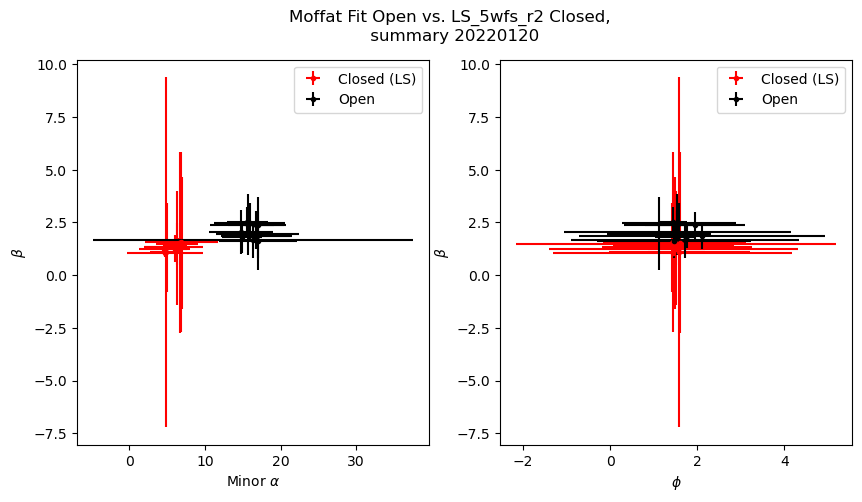

In [62]:
reload(plot_redu)
c_key = "LS_5wfs_r2"
plot_redu.plot_moffat_fit(root_dir, c_key, fld, night, o_key = "open_r2")

## Star STATS

In [17]:
suffixes = list(redu.dict_suffix.keys())
suffixes

['LS_3wfs_r1',
 'LS_5wfs_r1',
 'donut_r1',
 'open_r1',
 'LS_3wfs_r2',
 'LS_5wfs_r2',
 'open_r2']

In [63]:
#suffixes = list(redu.dict_suffix.keys())
suffixes = ['open_r2', 'LS_3wfs_r2', 'LS_5wfs_r2']

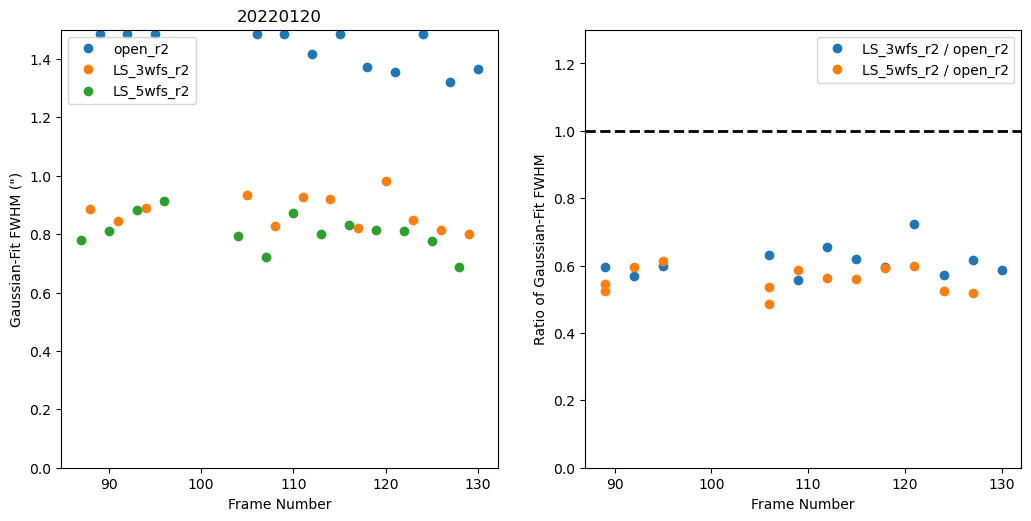

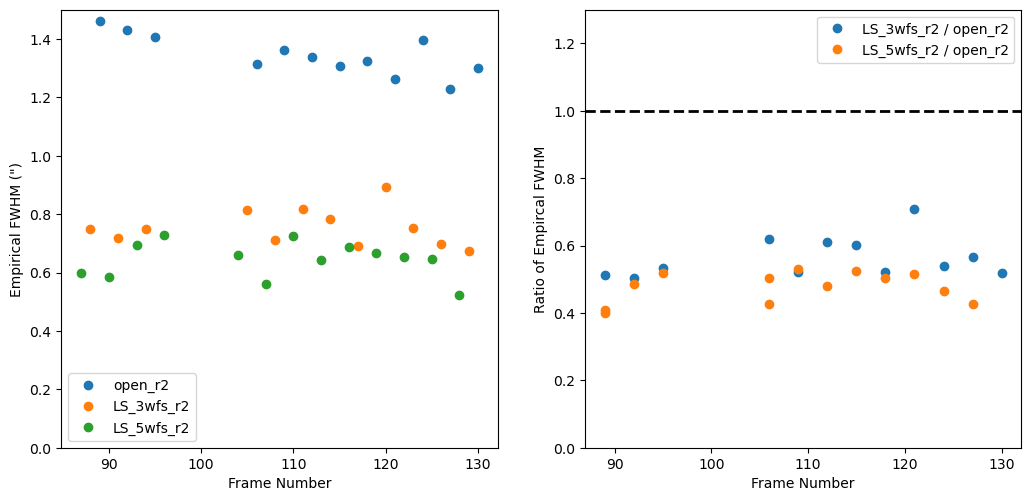

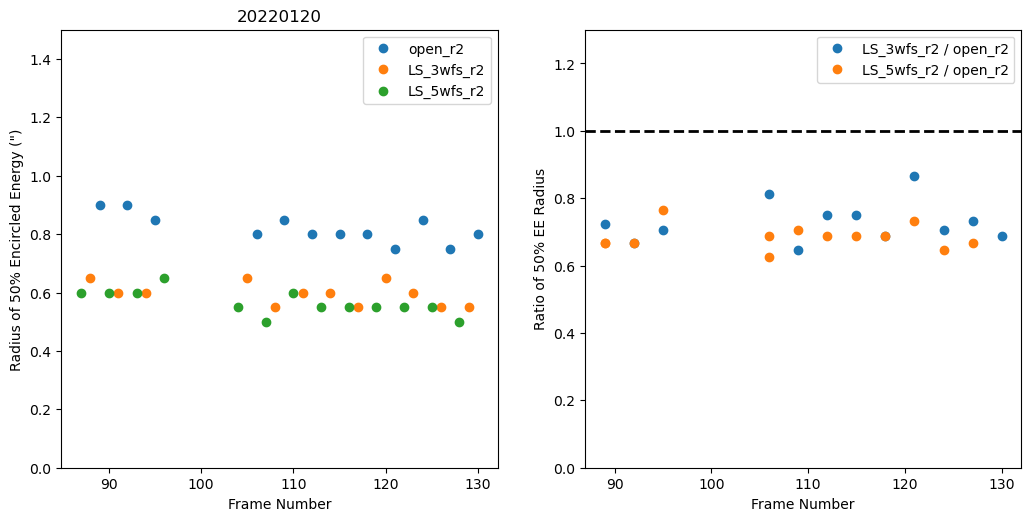

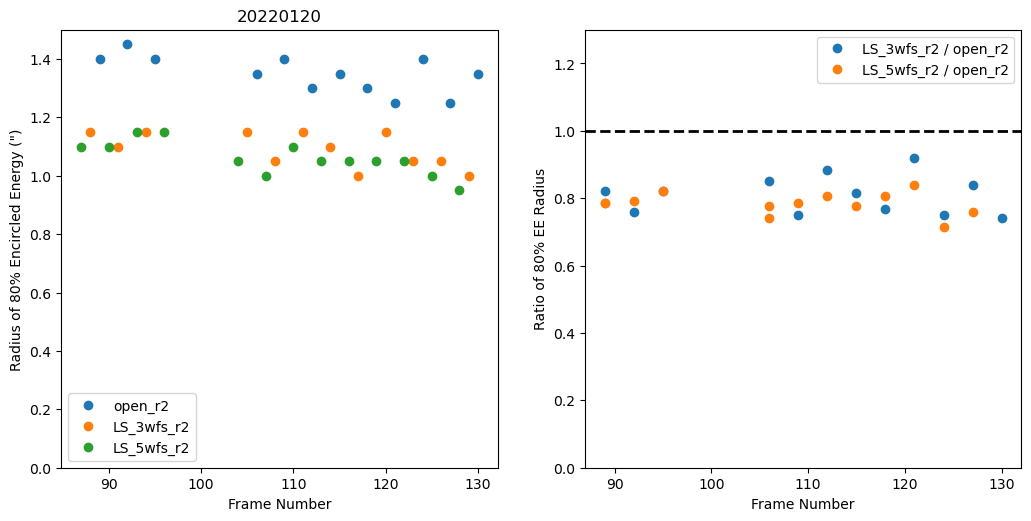

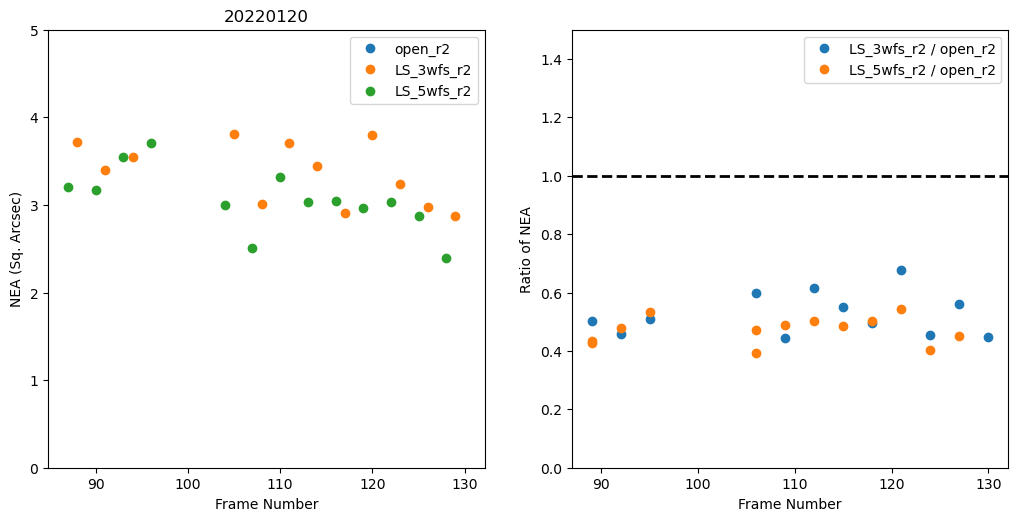

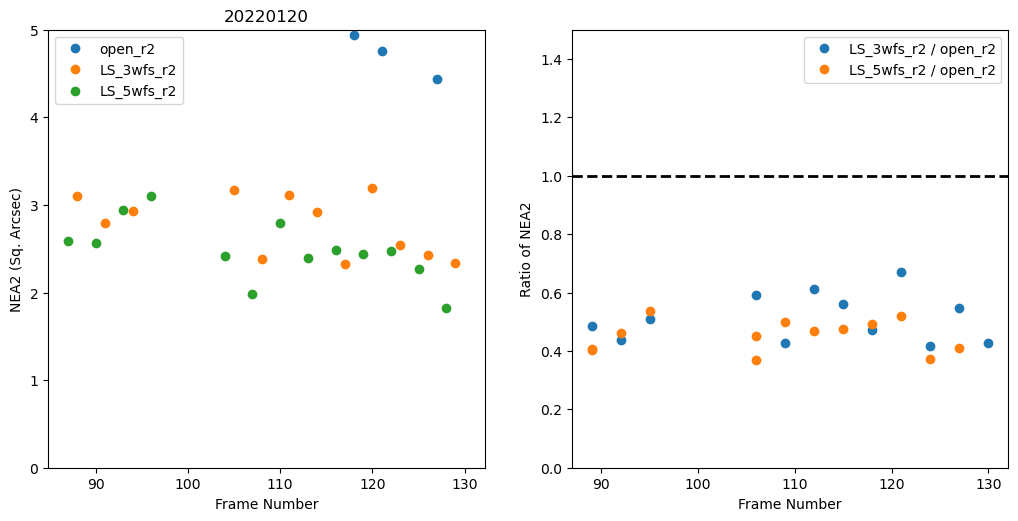

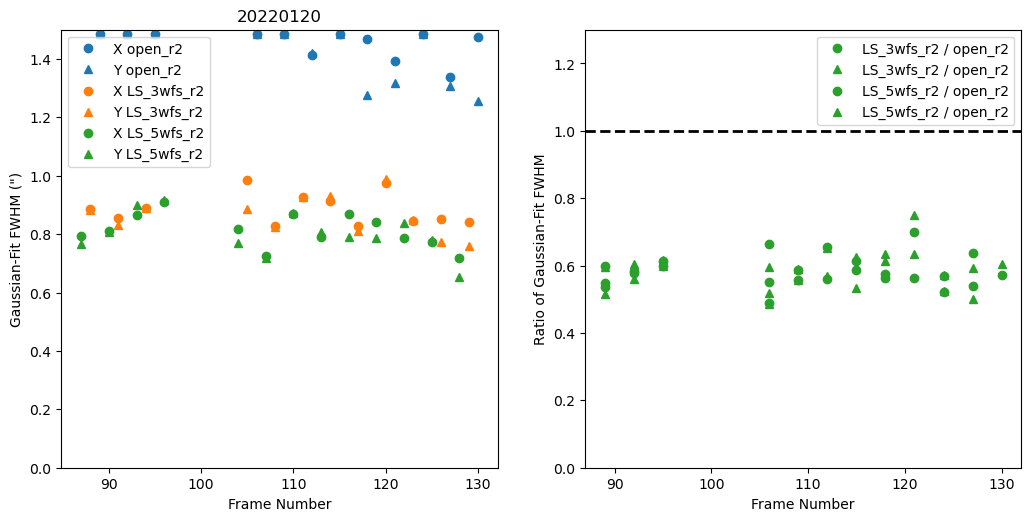

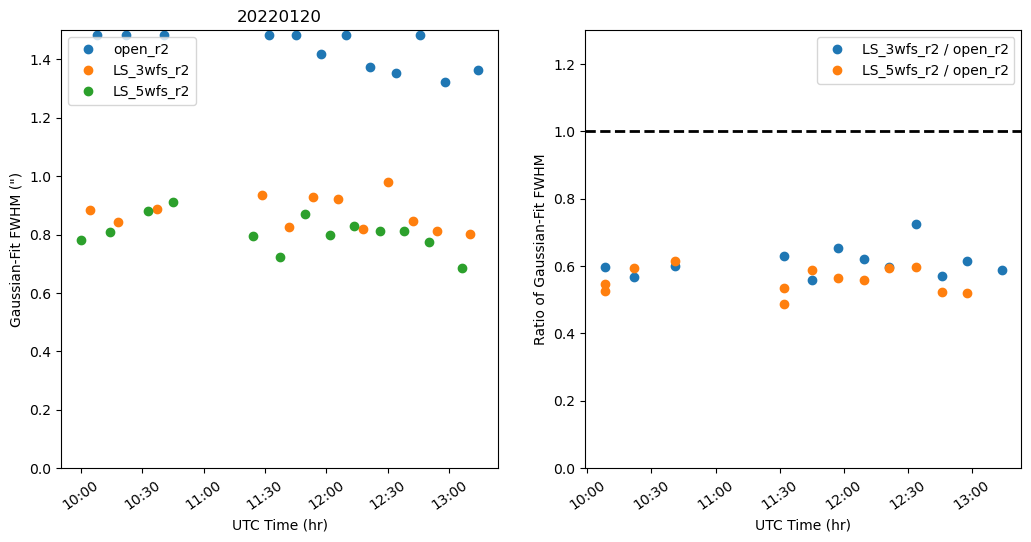

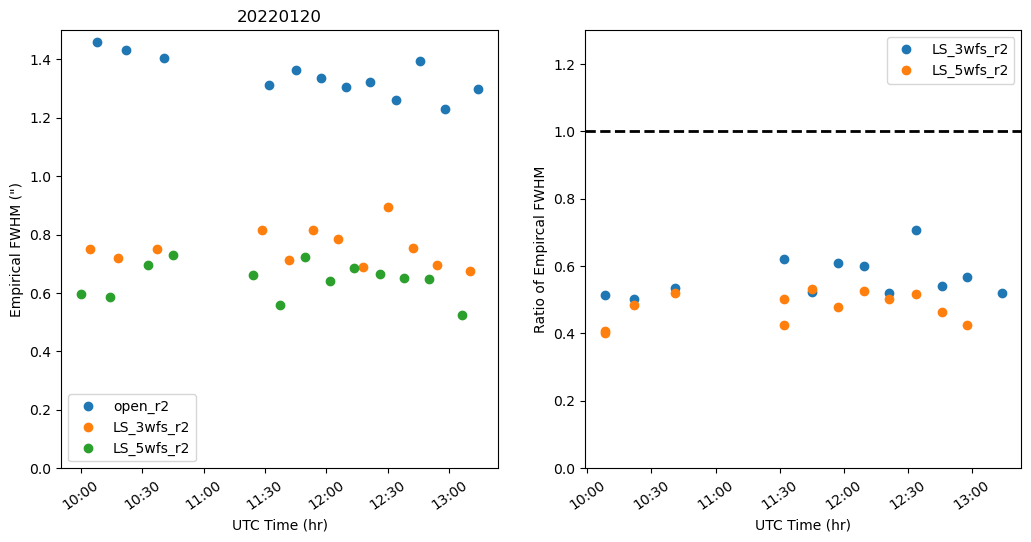

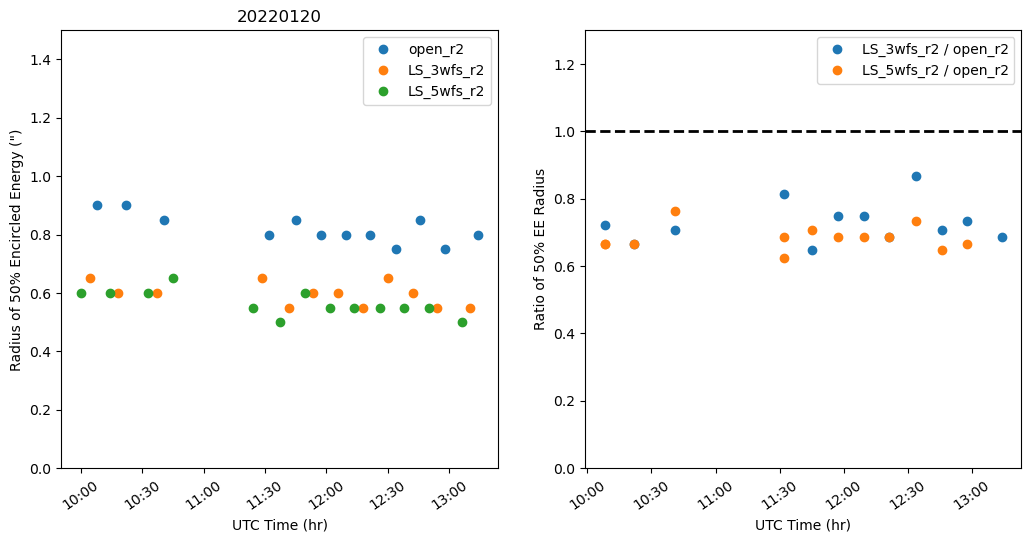

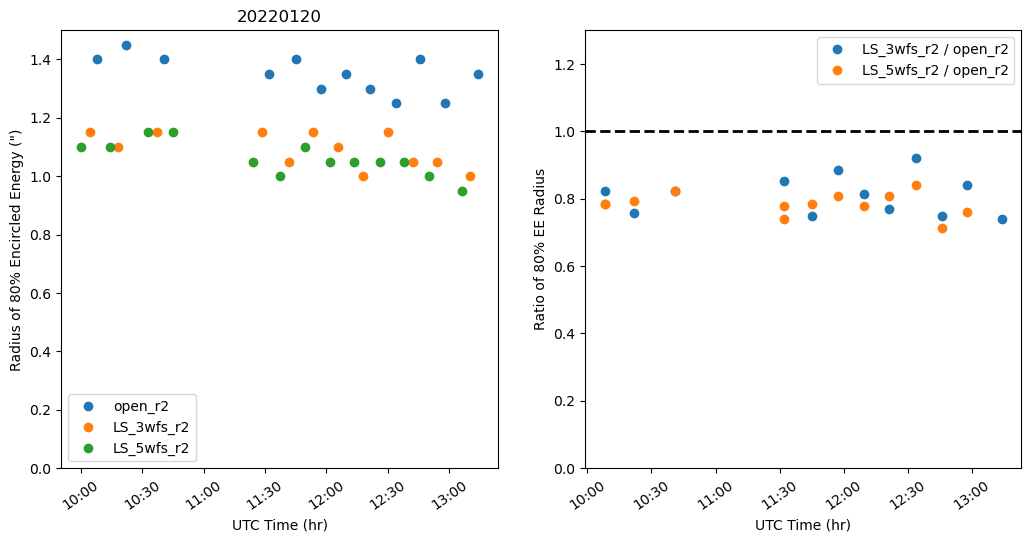

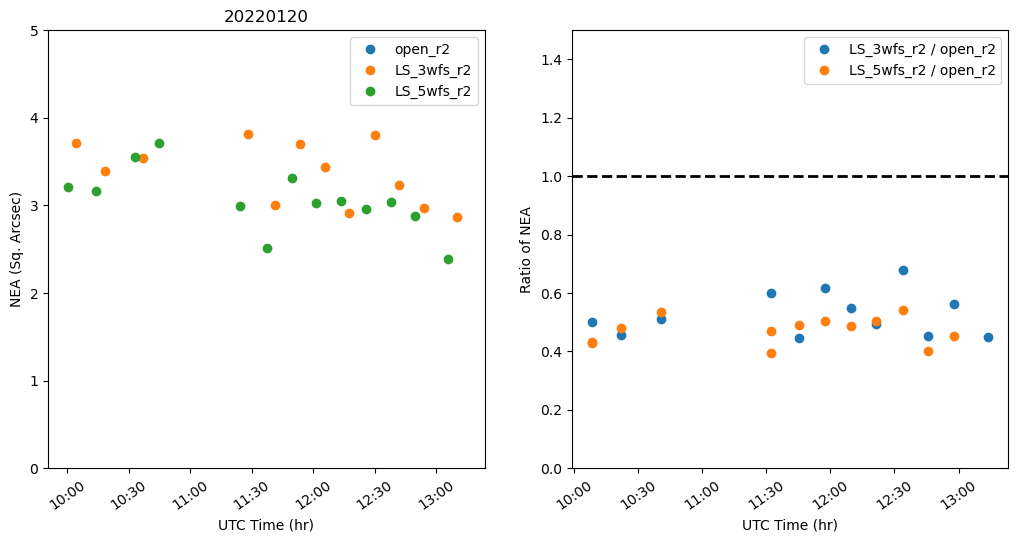

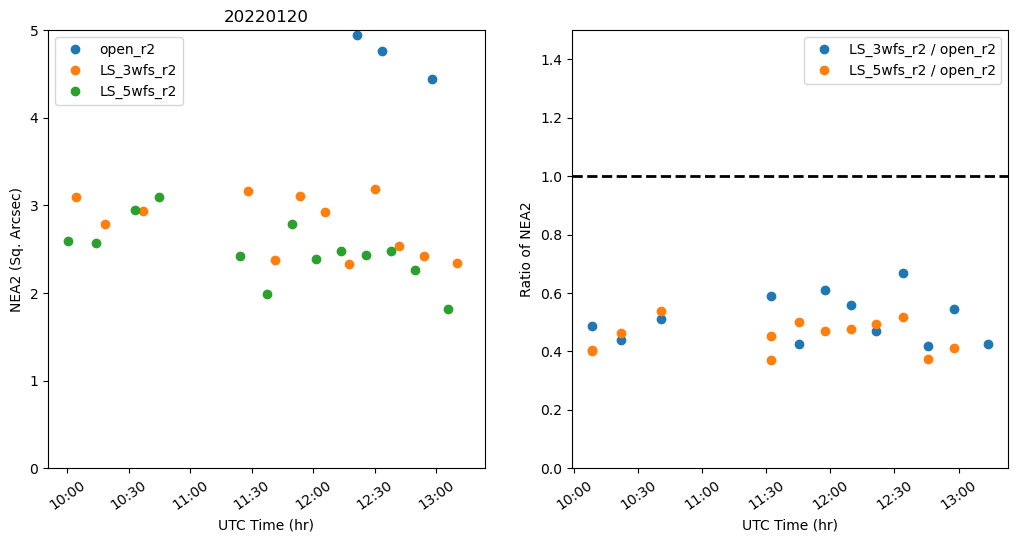

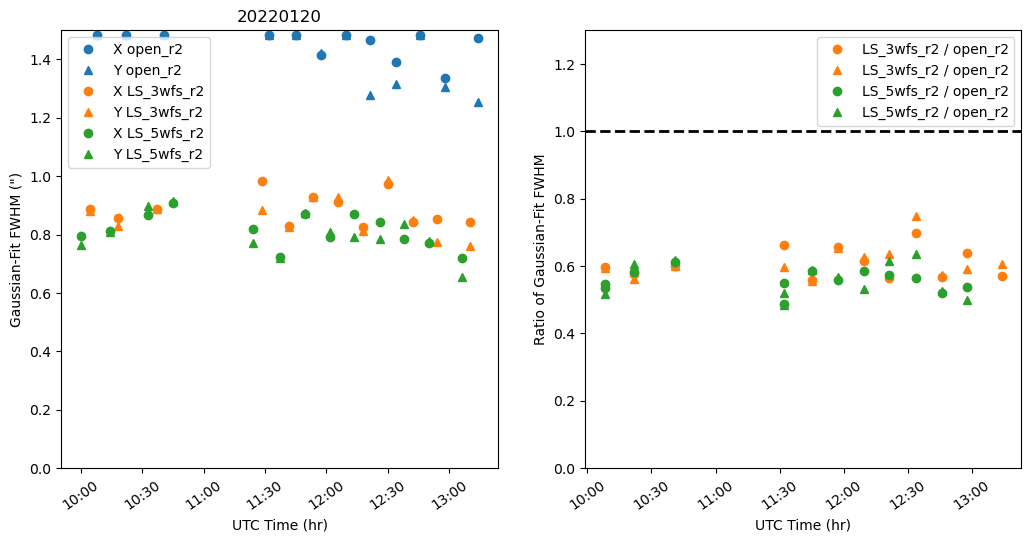

In [64]:
plot_stats.plot_stack_stats(night, suffixes=suffixes[-3:], root_dir=root_dir + '../../', reduce_dir='sta/reduce/')

# Time Variation w/MASS-DIMM

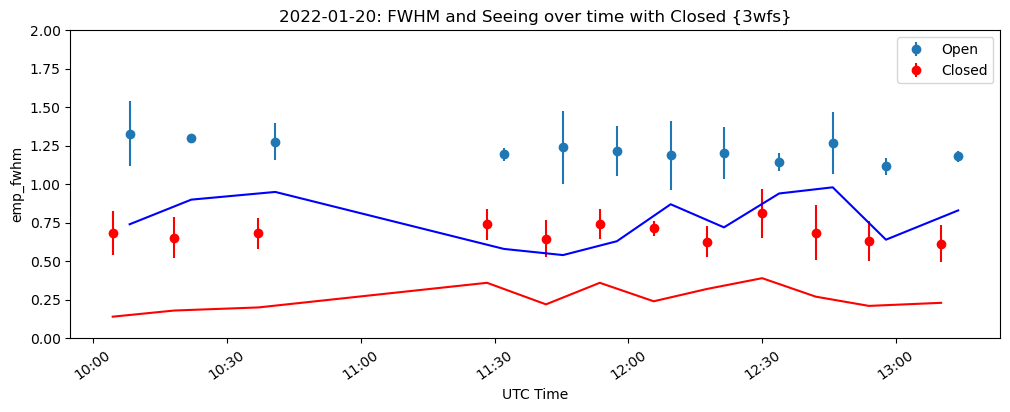

In [65]:
open_file = stats_dir +"stats_open_r2_mdp.fits"
closed_file1 = stats_dir+ "stats_LS_3wfs_r2_mdp.fits"
plot_stats.plot_fwhmvt_nomatch(open_file, closed_file1, 'emp_fwhm', "2022-01-20: FWHM and Seeing over time with Closed {3wfs}", plots_dir)

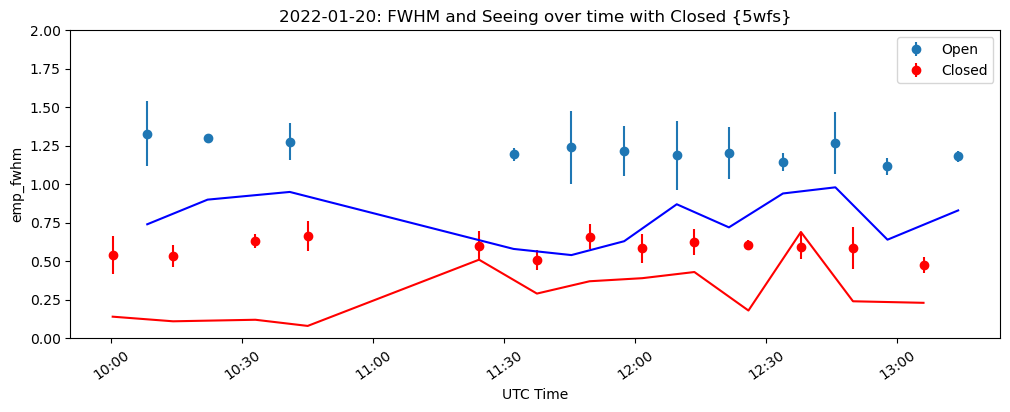

In [66]:
open_file = stats_dir +"stats_open_r2_mdp.fits"
closed_file2 = stats_dir+ "stats_LS_5wfs_r2_mdp.fits"
plot_stats.plot_fwhmvt_nomatch(open_file, closed_file2, 'emp_fwhm', "2022-01-20: FWHM and Seeing over time with Closed {5wfs}", plots_dir)

# Aggregate Plots

['/g/lu/data/imaka/onaga/20220120/sta/reduce/stats/stats_open_r2_mdp.fits', '/g/lu/data/imaka/onaga/20220120/sta/reduce/stats/stats_LS_3wfs_r2_mdp.fits', '/g/lu/data/imaka/onaga/20220120/sta/reduce/stats/stats_LS_5wfs_r2_mdp.fits']


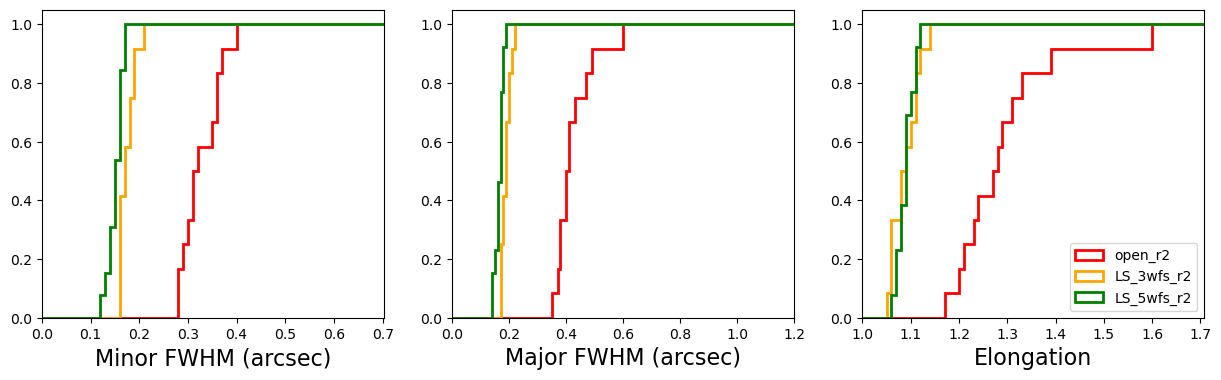

In [67]:
files = [stats_dir + 'stats_' + suffix + '_mdp.fits' for suffix in suffixes]
print(files)
colors = ['red', 'orange', 'green', 'blue', 'lightgreen', 'cyan']
plot_stats.comp_cdf(files, suffixes, colors)

# Field Variability

## Closed loop, single exposure

sta130_o_scan
Median FWHM           = 1.185"
Median FWHM (clipped) = 1.163"
Mean FWHM             = 1.360"
Mean FWHM (clipped)   = 1.176"
Stddev FWHM           = 0.659"
Stddev FWHM (clipped) = 0.078"


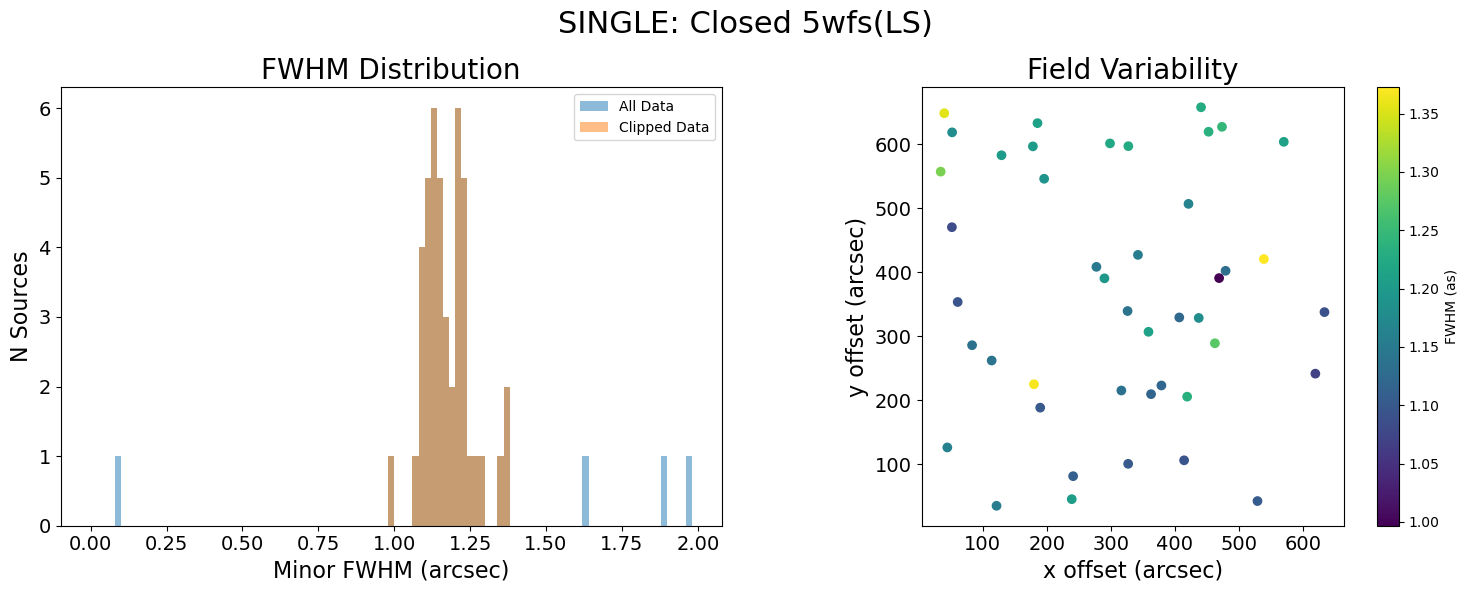

In [68]:
from importlib import reload
reload(plot_stats)
print(test_img_base)
img_file = root_dir + f'reduce/{fld}/{test_img_base}_clean.fits'
starlist = root_dir +  f'reduce/{fld}/{test_img_base}_clean_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, "SINGLE: Closed 5wfs(LS)")

sta090n5wfs_c_scan
Median FWHM           = 0.564"
Median FWHM (clipped) = 0.556"
Mean FWHM             = 0.552"
Mean FWHM (clipped)   = 0.437"
Stddev FWHM           = 0.498"
Stddev FWHM (clipped) = 0.239"


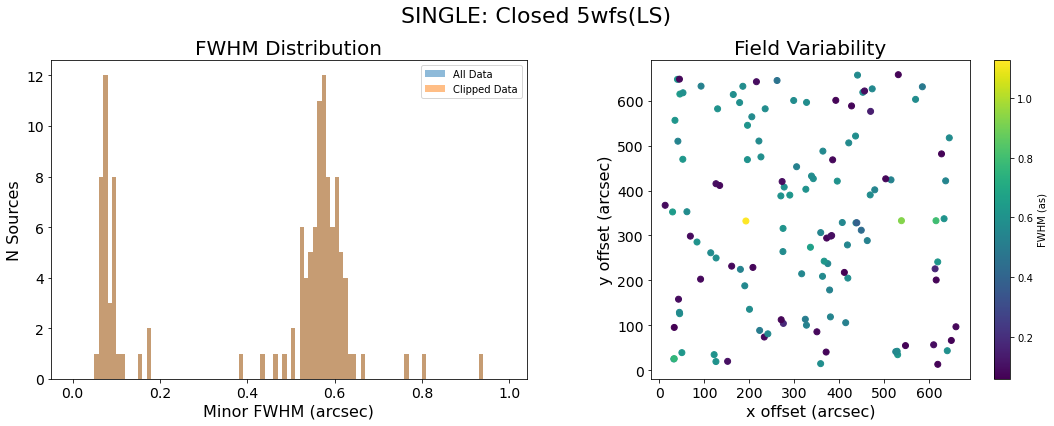

In [63]:
print(test_img_base)
img_file = root_dir + f'reduce/{fld}/{test_img_base}_clean.fits'
starlist = root_dir +  f'reduce/{fld}/{test_img_base}_clean_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, "SINGLE: Closed 5wfs(LS)")

### Open Loop

Median FWHM           = 1.257"
Median FWHM (clipped) = 1.253"
Mean FWHM             = 1.252"
Mean FWHM (clipped)   = 1.034"
Stddev FWHM           = 1.304"
Stddev FWHM (clipped) = 0.612"


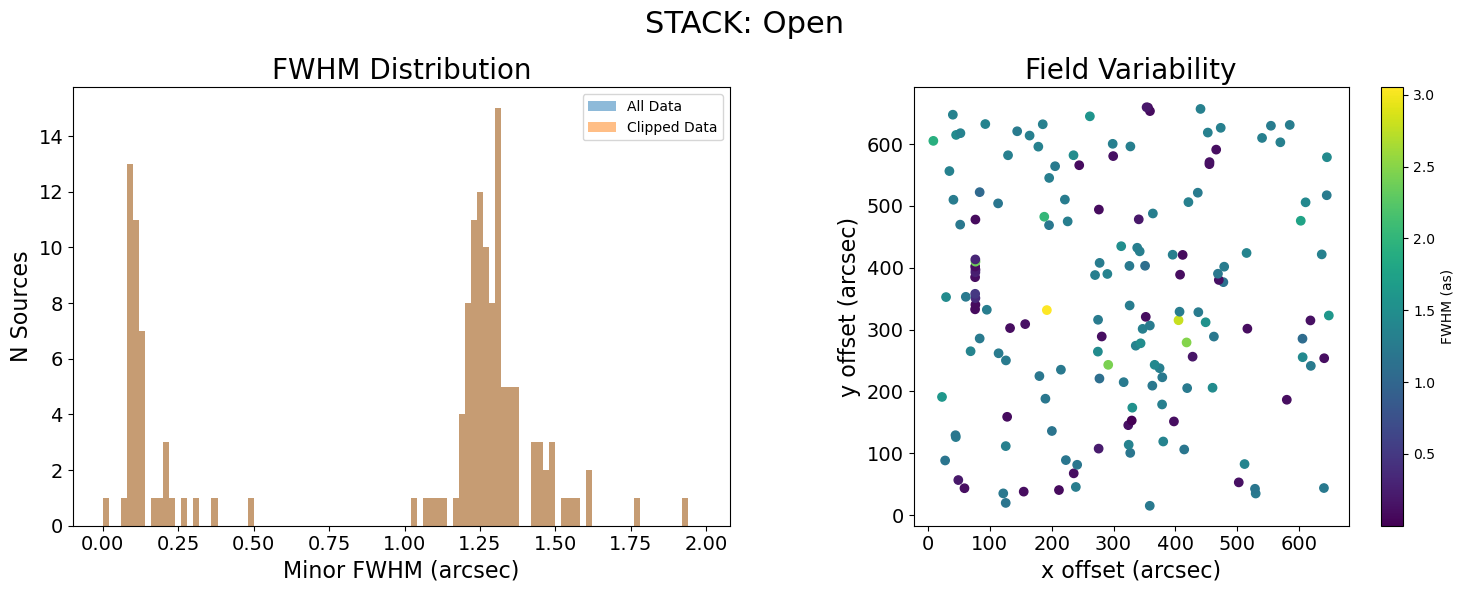

In [72]:
img_file = stack_dir + 'beehive_stack__o.fits' 
starlist = stack_dir + 'beehive_stack__o_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, "STACK: Open")

### Closed loop (3wfs)

Median FWHM           = 0.687"
Median FWHM (clipped) = 0.685"
Mean FWHM             = 0.662"
Mean FWHM (clipped)   = 0.594"
Stddev FWHM           = 0.606"
Stddev FWHM (clipped) = 0.254"


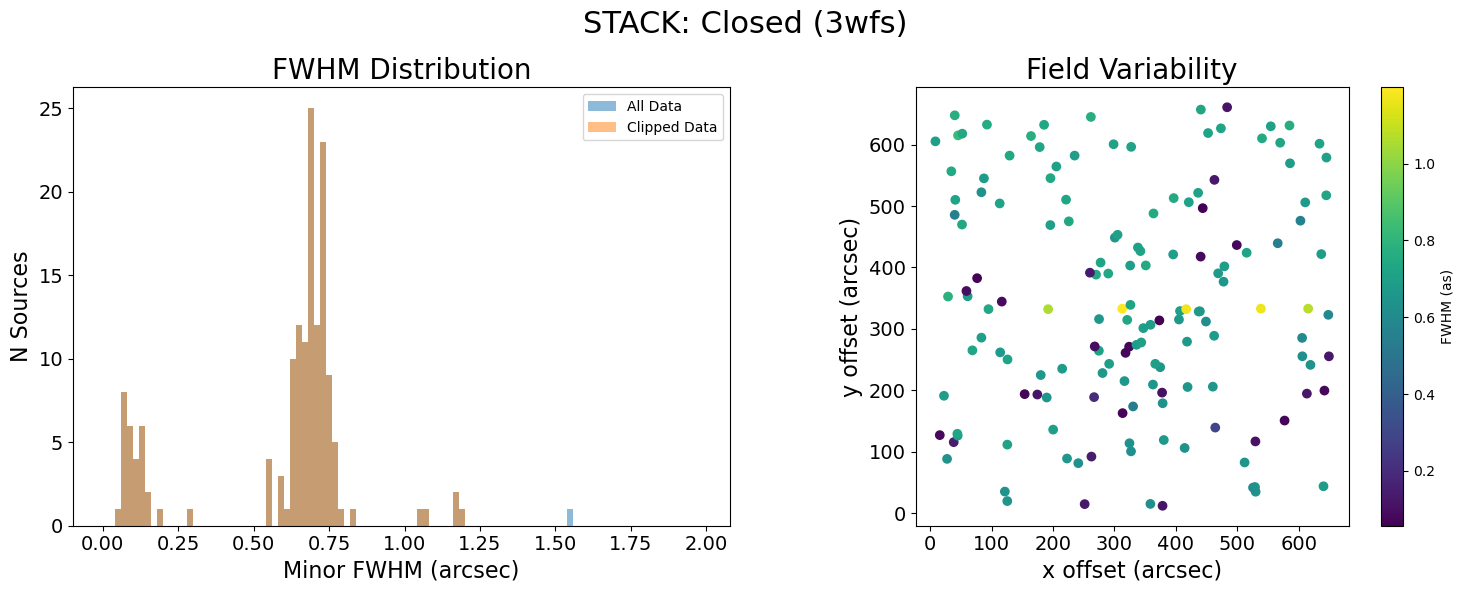

In [75]:
img_file = stack_dir + 'beehive_stack_n3wfs_c.fits' 
starlist = stack_dir + 'beehive_stack_n3wfs_c_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, "STACK: Closed (3wfs)")

### Closed loop (5wfs)

Median FWHM           = 0.600"
Median FWHM (clipped) = 0.598"
Mean FWHM             = 0.539"
Mean FWHM (clipped)   = 0.478"
Stddev FWHM           = 0.581"
Stddev FWHM (clipped) = 0.249"


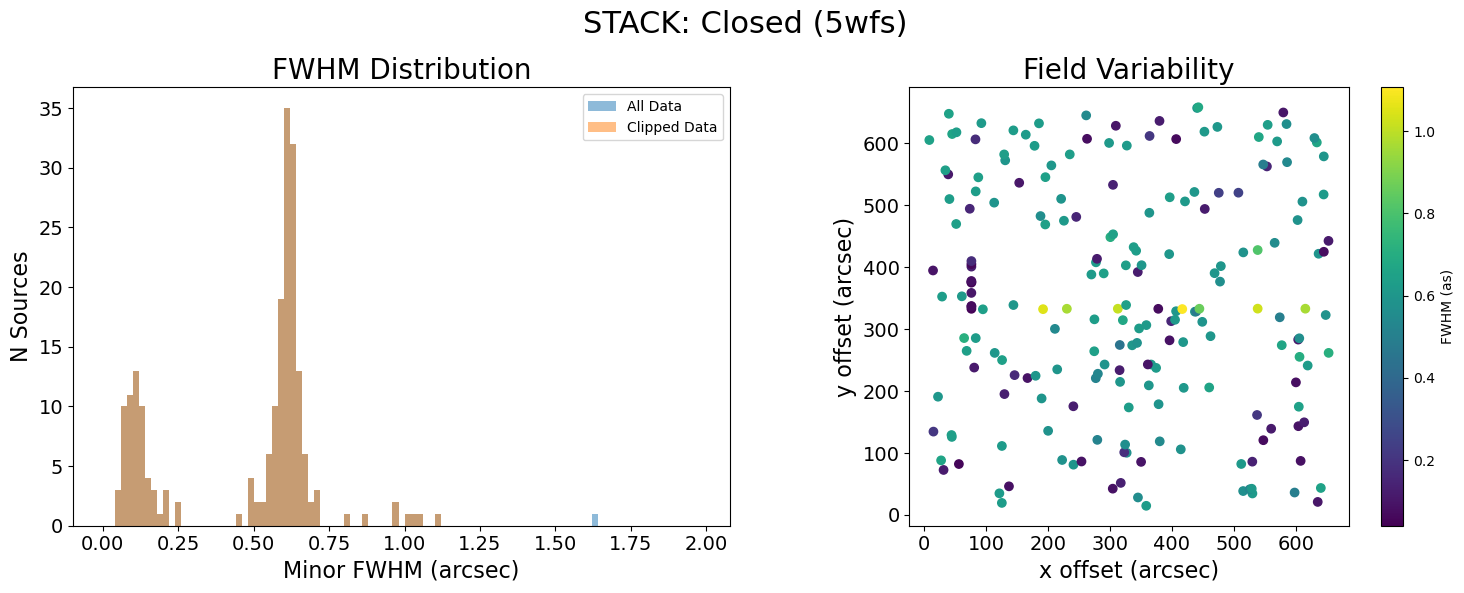

In [74]:
img_file = stack_dir + 'beehive_stack_n5wfs_c.fits'
starlist = stack_dir + 'beehive_stack_n5wfs_c_stars_stats_mdp.fits'
plot_stats.plot_var(img_file, starlist, "STACK: Closed (5wfs)")